# Marker Determination

In [ ]:
import sklearn as sk
import anndata as ad
import scanpy as sc 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import joblib

sc.settings.n_jobs = -1

In [ ]:
adata = ad.read_h5ad('data/camr_modeling_input.h5ad')
gene_names = adata.var["feature_name"].astype(str)
if not os.path.isfile('data/CAMR_genes.csv'):
    adata.var["feature_name"].to_csv('data/CAMR_genes.csv', index=False)
adata

## Major Class Markers

In [ ]:
top_features_log_reg = pd.read_csv('spreadsheets/ovr_top_20_genes_by_cell_type_reproduction.csv')

# Only positive features, negative markers are less useful
top_features_log_reg_pos = top_features_log_reg[top_features_log_reg['Coefficient'] > 0]
top_features_log_reg_pos.index = top_features_log_reg_pos.Gene
top_features_log_reg_pos

In [ ]:
# Now get average normalized expression
feature_expression_pd = pd.DataFrame(adata.X.toarray(), columns = gene_names.tolist())
feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()
feature_expression_pd_mean = feature_expression_pd.groupby("majorclass").agg("mean")
feature_expression_pd_mean

In [ ]:
# Raw average expression
highly_variable = adata.raw.var['feature_name'].isin(adata.var['feature_name'])
if not os.path.isfile('raw_mean_variable_genes.csv'):
    raw_feature_expression_pd = pd.DataFrame(adata.raw.X[:, highly_variable].toarray(), columns = gene_names.tolist())
    raw_feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()
    raw_feature_expression_pd_mean = raw_feature_expression_pd.groupby("majorclass").agg("mean")
else:
    raw_feature_expression_pd_mean = pd.read_csv('raw_mean_variable_genes.csv', index_col=0)
raw_feature_expression_pd_mean

In [ ]:
# Filter based on innate features of the gene itself
in_regression = adata.var["feature_name"].astype(str).isin(top_features_log_reg_pos["Gene"])
pre_filtered = adata.var["feature_is_filtered"] == False # variable genes, none filtered
long_enough = adata.var["feature_length"].astype(int) >= 960 # It's a conservative filter
known_markers = ["Cd74", "Gfap", "Tfap2b", "Rbpms", "Rlbp1", "Onecut1", "Arr3", "Neto1", "Pde6a"]
is_known = adata.var["feature_name"].isin(known_markers)
# with open("mentioned_genes.txt", 'r') as gene_file:
#     mentioned_genes = [gene.strip() for gene in gene_file.readlines()]
# is_mentioned = adata.var["feature_name"].isin(mentioned_genes)

baseline_genes = pre_filtered & long_enough & in_regression
keep_genes = baseline_genes | is_known # | (is_mentioned & baseline_genes) # Refactor? Missing "in top features"
kept_gene_names = gene_names[keep_genes].tolist()
print(len(kept_gene_names), kept_gene_names) # 218 genes still

In [ ]:
# Filter based on the filtering criteria
# adata.obs.library_platform.unique() # mix of 4 chemistries...

# count_noncluster = 0.1 # Absolute detection limit
count_noncluster = 0
count_highnoncluster = 4
count_lowcluster = 4
count_highcluster = 100

too_broad_genes = (raw_feature_expression_pd_mean >= count_highnoncluster).sum(axis=0) > 1
detectable_genes = (raw_feature_expression_pd_mean >= count_lowcluster).sum(axis=0) >= 1
optical_crowding_genes = (raw_feature_expression_pd_mean >= count_highcluster).sum(axis=0) > 0

poor_markers = optical_crowding_genes | too_broad_genes
is_expression_candidate = detectable_genes & (~poor_markers)

gene_names.index = is_expression_candidate.index # necessary step apparently
expression_candidates = gene_names[is_expression_candidate].tolist()
print(len(expression_candidates), expression_candidates) # 281

In [ ]:
final_candidates = np.intersect1d(expression_candidates, kept_gene_names)
print(len(final_candidates), final_candidates) # 113

In [ ]:
final_candidates_ordered = feature_expression_pd_mean[final_candidates].idxmax().sort_values()
sc.pl.dotplot(adata,
              final_candidates_ordered.index,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'RPE', 'Rod'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

In [ ]:
# Save all genes that passed these thresholds
raw_feature_expression_pd_mean[final_candidates_ordered.index].to_csv('spreadsheets/raw_majorclass_mean_expression.csv')
feature_expression_pd_mean[final_candidates_ordered.index].to_csv('spreadsheets/normalized_majorclass_mean_expression.csv')

In [ ]:
feature_cell = feature_expression_pd_mean[final_candidates].idxmax()
marker_expression_mean = [feature_expression_pd_mean[final_candidates].T.loc[row, feature_cell[i]] for i, row in enumerate(feature_expression_pd_mean[final_candidates].T.index)]
top3markers = pd.DataFrame([marker_expression_mean, final_candidates, feature_cell]).T.sort_values(0).groupby(2).tail(3)[1].tolist()
print(len(top3markers), top3markers)

In [ ]:
final_candidates_ordered_3 = feature_expression_pd_mean[top3markers].idxmax().sort_values()
sc.pl.dotplot(adata,
              final_candidates_ordered_3.index,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'RPE', 'Rod'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_top3_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

### Additional Inspection

In [ ]:
# count_lowcluster = 4
# count_highcluster = 100

features = raw_feature_expression_pd_mean.columns
detectable_genes = features[(raw_feature_expression_pd_mean >= count_lowcluster).sum(axis=0) >= 1]
optical_crowding_genes = features[(raw_feature_expression_pd_mean >= count_highcluster).sum() > 0]

detectable_range_genes = np.setdiff1d(detectable_genes, optical_crowding_genes)

long_enough = adata.var['feature_name'][adata.var["feature_length"].astype(int) >= 960] # It's a conservative filter
candidates = np.intersect1d(long_enough, detectable_range_genes)

final_candidates = np.intersect1d(top_features_log_reg_pos.Gene.tolist(), candidates)
print(len(final_candidates), final_candidates) # 172 if we remove some of the intricacies

In [ ]:
final_candidates_ordered = feature_expression_pd_mean[final_candidates].idxmax().sort_values().index
heatmap_subset = feature_expression_pd_mean[final_candidates_ordered]
heatmap_values = (heatmap_subset - heatmap_subset.mean(axis=None)) / heatmap_subset.std(axis=None)
heatmap_values

### Why are some marker values so weird???

In [ ]:
gene_of_interest = "Rbpms"

In [ ]:
# logistic regression coefficient is top 20 in one classes
top_features_log_reg_pos.loc[gene_of_interest]

In [ ]:
# However, baseline normalized expression of this gene is highest 
feature_expression_pd_mean[final_candidates].idxmax()[gene_of_interest]

In [ ]:
# All normalized expression by cell class
feature_expression_pd_mean[gene_of_interest]

In [ ]:
# All raw expression by cell class
raw_feature_expression_pd_mean[gene_of_interest]

In [ ]:
# All Z-transformed normalized expression by cell class
heatmap_values[gene_of_interest]

In [ ]:
for reg, Z in zip(top_features_log_reg_pos.loc[final_candidates]["Cell Type"].index, feature_expression_pd_mean[final_candidates].idxmax().index):
    print(reg == Z)

In [ ]:
for reg, Z in zip(top_features_log_reg_pos.loc[final_candidates]["Cell Type"].index, feature_expression_pd_mean[final_candidates].idxmax().index):
    print(reg, Z)

In [ ]:
heatmap_values.to_csv('spreadsheets/normalized_majorclass_Z_expression.csv')

In [ ]:
sc.pl.dotplot(adata,
              final_candidates_ordered,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'RPE', 'Rod'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_length-detection-logistic_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

In [ ]:
Zthres25 = heatmap_values.columns[((heatmap_values >= 2.5).sum(axis=0) == 1)]
final_candidates_ordered_Z25 = feature_expression_pd_mean[Zthres25].idxmax().sort_values().index
sc.pl.dotplot(adata,
              final_candidates_ordered_Z25,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = ['AC', 'Astrocyte', 'BC', 'Cone', 'Endothelial', 'HC', 'MG', 'Microglia', 'Pericyte', 'RGC', 'RPE', 'Rod'],
              vmax = count_highnoncluster,
              vmin = 0,
              save = f"mouseRetina_filteredCounts_length-detection-logistic_Z2.5_" +
                     f"{count_noncluster}-{count_highnoncluster}count{count_lowcluster}-{count_highcluster}.png")

### Major Class Markers Final Pipeline

In [ ]:
top_features_log_reg = pd.read_csv('spreadsheets/ovr_top_20_genes_by_cell_type_reproduction.csv')

# Only positive features, negative markers are less useful
top_features_log_reg_pos = top_features_log_reg[top_features_log_reg['Coefficient'] > 0]
top_features_log_reg_pos.index = top_features_log_reg_pos.Gene
top_features_log_reg_pos

In [ ]:
# Average normalized expression
feature_expression_pd = pd.DataFrame(adata.X.toarray(), columns = gene_names.tolist())
feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()
feature_expression_pd_mean = feature_expression_pd.groupby("majorclass").agg("mean")
feature_expression_pd_mean

In [ ]:
# Raw average expression
highly_variable = adata.raw.var['feature_name'].isin(adata.var['feature_name'])
if not os.path.isfile('spreadsheets/raw_mean_variable_genes.csv'):
    raw_feature_expression_pd = pd.DataFrame(adata.raw.X[:, highly_variable].toarray(), columns = gene_names.tolist())
    raw_feature_expression_pd["majorclass"] = adata.obs["majorclass"].tolist()
    raw_feature_expression_pd_mean = raw_feature_expression_pd.groupby("majorclass").agg("mean")
    raw_feature_expression_pd_mean.write_csv('spreadsheets/raw_mean_variable_genes.csv')
else:
    raw_feature_expression_pd_mean = pd.read_csv('raw_mean_variable_genes.csv', index_col=0)
raw_feature_expression_pd_mean

In [ ]:
# Filter based on innate features of the gene itself
in_regression = adata.var["feature_name"].astype(str).isin(top_features_log_reg_pos["Gene"])
long_enough = adata.var["feature_length"].astype(int) >= 960 # It's a conservative filter

keep_genes = long_enough & in_regression
kept_gene_names = gene_names[keep_genes].tolist()
print(len(kept_gene_names), kept_gene_names) # 218 genes still

In [ ]:
# Filter based on the filtering criteria
# adata.obs.library_platform.unique() # mix of 4 chemistries...

# count_limit = 0.1 # Absolute detection limit
count_lowcluster = 4
count_highcluster = 100

detectable_genes = (raw_feature_expression_pd_mean >= count_lowcluster).sum(axis=0) >= 1
optical_crowding_genes = (raw_feature_expression_pd_mean >= count_highcluster).sum(axis=0) > 0

is_expression_candidate = detectable_genes & (~optical_crowding_genes)

gene_names.index = is_expression_candidate.index # necessary step apparently
expression_candidates = gene_names[is_expression_candidate].tolist()
print(len(expression_candidates), expression_candidates) # 428 genes

In [ ]:
final_candidates = np.intersect1d(expression_candidates, kept_gene_names)
print(len(final_candidates), final_candidates) # 173 genes

In [ ]:
ordred_features = top_features_log_reg_pos.loc[final_candidates.tolist()].sort_values('Cell Type').index

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


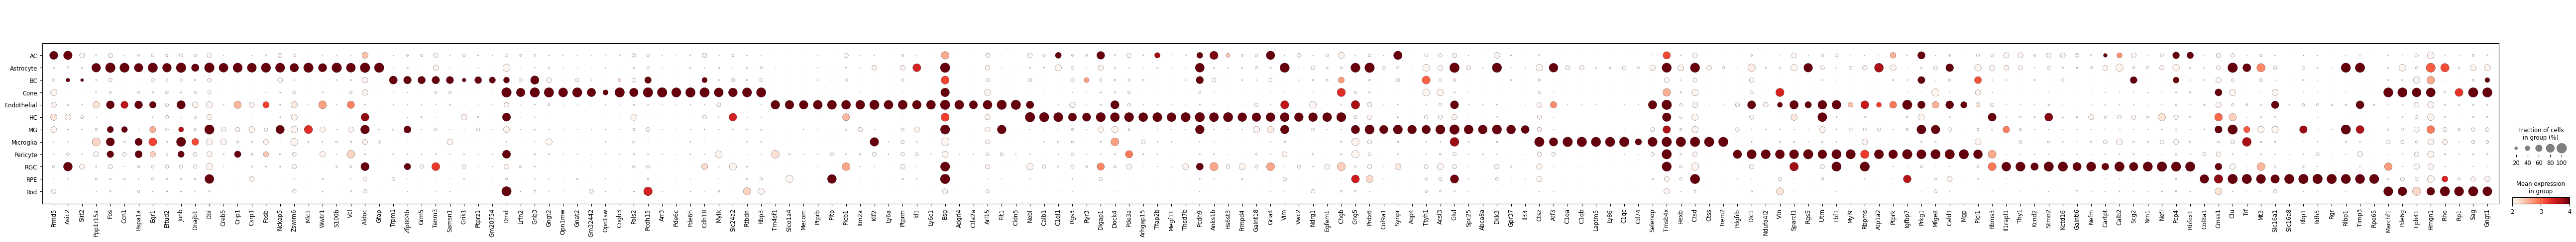

In [147]:
sc.pl.dotplot(adata,
              var_names = ordred_features,
              gene_symbols="feature_name",
              groupby = 'majorclass',
              categories_order = adata.obs["majorclass"].cat.categories.sort_values(),
              vmax = count_lowcluster,
              vmin = count_lowcluster / 2,
              save = f"mouseRetina_filteredCounts_" +
                     f"count{count_lowcluster}-{count_highcluster}.pdf")

In [ ]:
# Save all genes that passed these thresholds -- sensitive since there is no specificity filter
final_candidates_ordered = feature_expression_pd_mean[final_candidates].idxmax().sort_values().index
raw_feature_expression_pd_mean[final_candidates_ordered].to_csv('spreadsheets/ovr_top_filtered_genes_majorclass_rawMeanExpression_sensitive.csv')
feature_expression_pd_mean[final_candidates_ordered].to_csv('spreadsheets/ovr_top_filtered_genes_majorclass_normMeanExpression_sensitive.csv')
top_features_log_reg_pos.loc[final_candidates.tolist()].to_csv('spreadsheets/ovr_top_filtered_genes_majorclass_normMeanExpression_sensitive.csv')

## Subtype Markers

In [ ]:
top_features_log_reg_sub = pd.read_csv('spreadsheets/ovr_top_20_genes_by_sub_cell_type_reproduction.csv')
top_features_log_reg_pos_sub = top_features_log_reg_sub[top_features_log_reg_sub['Coefficient'] > 0]
top_features_log_reg_pos_sub

In [ ]:
# Average normalized expression
feature_expression_sub = pd.DataFrame(adata.X.toarray(), columns = gene_names.tolist())
feature_expression_sub["author_cell_type"] = adata.obs["author_cell_type"].tolist()
feature_expression_sub_mean = feature_expression_sub.groupby("author_cell_type").agg("mean")
feature_expression_sub_mean

In [ ]:
# Raw average expression
highly_variable = adata.raw.var['feature_name'].isin(adata.var['feature_name'])
if not os.path.isfile('spreadsheets/raw_subtype_mean_variable_genes.csv'):
    raw_feature_expression_sub = pd.DataFrame(adata.raw.X[:, highly_variable].toarray(), columns = gene_names.tolist())
    raw_feature_expression_sub["author_cell_type"] = adata.obs["author_cell_type"].tolist()
    raw_feature_expression_sub_mean = raw_feature_expression_sub.groupby("author_cell_type").agg("mean")
    raw_feature_expression_sub_mean.write_csv('spreadsheets/raw_subtype_mean_variable_genes.csv')
else:
    raw_feature_expression_sub_mean = pd.read_csv('spreadsheets/raw_subtype_mean_variable_genes.csv', index_col=0)
raw_feature_expression_sub_mean

In [ ]:
# Filter based on innate features of the gene itself
in_regression = adata.var["feature_name"].astype(str).isin(top_features_log_reg_pos_sub["Gene"])
long_enough = adata.var["feature_length"].astype(int) >= 960 # It's a conservative filter

keep_genes = long_enough & in_regression
kept_gene_names = gene_names[keep_genes].tolist()
print(len(kept_gene_names), kept_gene_names) # 680

In [ ]:
# Filter based on the filtering criteria
# adata.obs.library_platform.unique() # mix of 4 chemistries...

# count_limit = 0.1 # Absolute detection limit
count_lowcluster = 4
count_highcluster = 100

detectable_genes = (raw_feature_expression_sub_mean >= count_lowcluster).sum(axis=0) >= 1
optical_crowding_genes = (raw_feature_expression_sub_mean >= count_highcluster).sum(axis=0) > 0

is_expression_candidate = detectable_genes & (~optical_crowding_genes)

gene_names.index = is_expression_candidate.index # necessary step apparently
expression_candidates = gene_names[is_expression_candidate].tolist()
print(len(expression_candidates), expression_candidates) # 669 genes

In [ ]:
final_candidates = np.intersect1d(expression_candidates, kept_gene_names)
print(len(final_candidates), final_candidates) # 479 genes

In [ ]:
# Can't check classes because of known markers
final_candidates_ordered_sub = feature_expression_sub_mean[final_candidates].idxmax().sort_values().index
sc.pl.dotplot(adata,
              final_candidates_ordered_sub,
              gene_symbols="feature_name",
              groupby = 'author_cell_type',
              vmax = count_lowcluster,
              vmin = count_lowcluster / 2,
              save = f"mouseRetina_filteredCounts_subtype_" +
                     f"count{count_lowcluster}-{count_highcluster}.png")

In [ ]:
# Save all genes that passed these thresholds -- sensitivity but less specificity
raw_feature_expression_sub_mean[final_candidates_ordered_sub].to_csv('spreadsheets/raw_sub_mean_expression_sensitive.csv')
feature_expression_sub_mean[final_candidates_ordered_sub].to_csv('spreadsheets/normalized_sub_mean_expression_sensitive.csv')

In [ ]:
del feature_expression_sub, feature_expression_sub_mean

### Subtype Marker Better Plots

Requirements:

* adata
* final_candidates_ordered
* final_candidates_ordered_sub
* count_lowcluster
* count_highcluster

In [1]:
continuing = False # Are you running this after running everything above?

In [19]:
if not continuing:

    import sklearn as sk
    import anndata as ad
    import scanpy as sc 
    import matplotlib.pyplot as plt
    import pandas as pd
    import numpy as np
    import os
    import joblib

    sc.settings.n_jobs = -1
    
    count_lowcluster = 4
    count_highcluster = 100
    
    adata = ad.read_h5ad('data/camr_modeling_input.h5ad')
    adata.var.index = adata.var["feature_name"] # subset on genes instead of booleans

    final_candidates_ordered = pd.read_csv('spreadsheets/normalized_majorclass_mean_expression_sensitive.csv', index_col = 0).idxmax()
    final_candidates_ordered_sub = pd.read_csv('spreadsheets/normalized_sub_mean_expression_sensitive.csv', index_col = 0).idxmax()

In [23]:
majorclass = final_candidates_ordered.unique()
minorclass = final_candidates_ordered_sub.unique() # Not necessary
print(majorclass, minorclass)

['AC' 'Astrocyte' 'BC' 'Cone' 'Endothelial' 'HC' 'MG' 'Microglia'
 'Pericyte' 'RGC' 'RPE' 'Rod'] ['10_Novel' '11_Novel' '12_ooDS_NT' '15_Novel' '16_ooDS_DV' '19_Novel'
 '1_W3D1.1' '20_Novel' '21_Tbr1_S2' '22_M5' '23_W3D2' '27_Novel'
 '28_FmidiOFF' '2_W3D1.2' '30_Novel' '31_M2' '32_F_Novel' '33_M1'
 '3_FminiON' '40_M1dup' '41_AlphaONT' '42_AlphaOFFS' '43_AlphaONS'
 '44_Novel' '45_AlphaOFFT' '6_W3B' '7_Novel' '9_Tbr1_Novel' 'AC_1' 'AC_10'
 'AC_11' 'AC_12' 'AC_13' 'AC_15' 'AC_17' 'AC_18' 'AC_19' 'AC_2' 'AC_20'
 'AC_21' 'AC_22' 'AC_23' 'AC_24' 'AC_25' 'AC_26' 'AC_27' 'AC_28' 'AC_29'
 'AC_3' 'AC_30' 'AC_31' 'AC_32' 'AC_33' 'AC_34' 'AC_35' 'AC_36' 'AC_37'
 'AC_39' 'AC_4' 'AC_40' 'AC_41' 'AC_42' 'AC_43' 'AC_44' 'AC_46' 'AC_48'
 'AC_49' 'AC_5' 'AC_50' 'AC_51' 'AC_52' 'AC_53' 'AC_55' 'AC_57' 'AC_58'
 'AC_59' 'AC_6' 'AC_60' 'AC_61' 'AC_62' 'AC_63' 'Astrocyte' 'BC1A' 'BC1B'
 'BC2' 'BC3A' 'BC3B' 'BC4' 'BC5A' 'BC5B' 'BC5C' 'BC5D' 'BC6' 'BC7' 'BC8'
 'BC9' 'Cone' 'Endothelial' 'HC' 'MG' 'Microglia' '

In [31]:
subtype_to_type = adata.obs[["author_cell_type", "majorclass"]].groupby("author_cell_type").head(1)
subtype_to_type.groupby("majorclass").agg("count").to_csv('spreadsheets/number_of_subtypes.csv')
subtype_to_type

/tmp/ipykernel_142855/2922769259.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subtype_to_type = adata.obs[["author_cell_type", "majorclass"]].groupby("author_cell_type").head(1)


,author_cell_type,majorclass
10x3_Ms_WT_P14_AAACCCAAGGGATCTG-1,RBC,BC
10x3_Ms_WT_P14_AAACCCAGTAGCTAAA-1,Rod,Rod
10x3_Ms_WT_P14_AAACCCATCGGCCCAA-1,MG,MG
10x3_Ms_WT_P14_AAACGAAAGACTCTAC-1,BC6,BC
10x3_Ms_WT_P14_AAACGAACAATGTTGC-1,BC5A,BC
...,...,...
rgc_T8_MPTK_2-CATCGTCGTACAAGCG-1,AC_54,AC
MouseACS2_CCGTGGAGTGCAACGA-1,AC_53,AC
MouseACS5_GGTGTTACAGGTCCAC-1,AC_62,AC
CTRLC57AllOther1_GCATGTACAGTCGTGC-1,Astrocyte,Astrocyte


In [124]:
for cell in majorclass:

    cell_markers = final_candidates_ordered[final_candidates_ordered == cell].index
    subtypes = subtype_to_type.loc[subtype_to_type.majorclass == cell, "author_cell_type"].tolist()
    subtype_markers = final_candidates_ordered_sub[final_candidates_ordered_sub.isin(subtypes)].index

    markers = cell_markers.tolist() + subtype_markers.tolist()
    unique_markers = []
    for m in markers:
        if m not in unique_markers:
            unique_markers += [m]

    sc.pl.dotplot(adata[adata.obs.majorclass == cell, unique_markers],
                  unique_markers,
                  gene_symbols="feature_name",
                  groupby = 'author_cell_type',
                  vmax = count_lowcluster * 3,
                  vmin = count_lowcluster - 1,
                  show = False,
                  save = f"mouseRetina_filteredCounts_subtype_{cell}_" +
                         f"count{count_lowcluster}-{count_highcluster}.pdf")

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/appl/python-3.11/lib/python3.11/s

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
/appl/python-3.11/lib/python3.11/s

/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:168: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  obs_bool.groupby(level=0).sum() / obs_bool.groupby(level=0).count()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:178: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dot_color_df = self.obs_tidy.groupby(level=0).mean()
/appl/python-3.11/lib/python3.11/site-packages/scanpy/plotting/_dotplot.py:747: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)
